In [38]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import pmlb
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/multitask_gam_mar12/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/03_multitask_gam.py'
d = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
d = imodelsx.process_results.average_over_seeds(
    d, experiment_filename, key_to_average_over='seed'
)
d = d[~d.dataset_name.str.contains('_fri_')]


# checking
cols_varied = imodelsx.process_results.get_experiment_keys(
    d, experiment_filename)
print('experiment varied these params:', cols_varied)
if not 'roc_auc_test' in d:
    d['roc_auc_test'] = np.nan
BEST_PARAMS = {
    'linear_penalty': 'ridge',
    'n_boosting_rounds': 0,
    'interactions': 0.95,
    'use_onehot_prior': 0,
    'use_input_normalization': 1,
    'use_internal_classifiers': 0,
    'use_normalize_feature_targets': 0,
    'train_frac': 0.8,
    'use_fit_target_curves': 1,
    'max_rounds': 5000,
}
for col in cols_varied:
    assert col in ['dataset_name', 'use_multitask'] or col in BEST_PARAMS, col + 'must be in BEST_PARAMS!'

print('num_datasets run in different groups',)
display(d.groupby([x for x in cols_varied if not x == 'dataset_name']).size())

# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_normalize_feature_targets], actually_delete=True)
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[(r.use_multitask == 0) * (r.linear_penalty != 'ridge')], actually_delete=True)
# imodelsx.process_results.get_experiment_keys(r, experiment_filename)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 241/241 [00:03<00:00, 72.60it/s] 


experiment varied these params: ['dataset_name', 'use_multitask', 'n_boosting_rounds', 'max_rounds']
num_datasets run in different groups


use_multitask  n_boosting_rounds  max_rounds
0              0                  5000          65
1              0                  5000          28
               2                  100           28
               4                  100           32
               8                  50            33
dtype: int64

### Compare baseline to best setting

,setting,n_datasets,frac_improved,median_change,median_multitask,avg_change,avg_multitask
0,All,28,0.393,-0.006,0.761,-0.010,0.698
1,>=100 samples,24,0.333,-0.006,0.761,-0.012,0.692
2,>=1000 samples,10,0.300,-0.003,0.718,-0.009,0.688
3,>=10000 samples,6,0.333,-0.000,0.642,-0.002,0.679
4,>=10 features,11,0.455,-0.000,0.853,-0.005,0.783
5,Well predicted,21,0.524,0.000,0.807,-0.003,0.815
6,PMLB,24,0.375,-0.006,0.761,-0.010,0.708


top dsets


use_multitask,dataset_name,standard,multitask,num_features,num_samples,feature_over_samples,improvement
25,friedman1,0.84,0.89,10.0,160.0,0.06,0.05
4,1089_USCrime,0.76,0.79,13.0,37.0,0.35,0.03
12,228_elusage,0.78,0.81,2.0,44.0,0.05,0.03
13,230_machine_cpu,0.90,0.91,6.0,167.0,0.04,0.01
26,friedman3,0.98,0.99,4.0,160.0,0.02,0.01
18,561_cpu,0.98,0.99,7.0,167.0,0.04,0.01
22,706_sleuth_case1202,0.61,0.62,6.0,74.0,0.08,0.01
11,218_house_8L,0.68,0.68,8.0,18227.0,0.00,0.00
17,560_bodyfat,0.95,0.95,14.0,201.0,0.07,0.00
8,197_cpu_act,0.98,0.98,21.0,6553.0,0.00,0.00


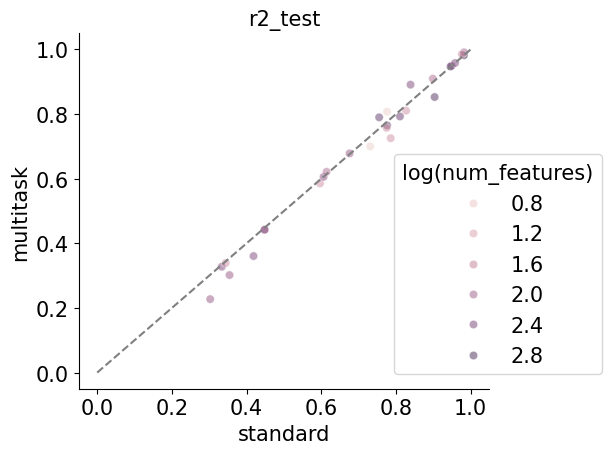

In [39]:
# filter datasets for which there is a row with use_multitask=0 and use_multitask=1 (done running)
def evaluate(d, metric='r2_test'):
    d2 = d.groupby(['dataset_name'])
    d2 = d2.filter(lambda x: len(x) == 2)

    # pivot table for d2 based on dataset_name, use_multitask, and r2_test
    metric_table = d2.pivot_table(index=['dataset_name'], columns=[
        'use_multitask'], values=metric)

    # add num_features based on dataset_name
    n_features = d2.groupby(['dataset_name']).first().n_features
    n_samples = d2.groupby(['dataset_name']).first().n_samples

    # add some metadata filters
    metric_table['num_features'] = n_features
    metric_table['num_samples'] = n_samples
    metric_table['feature_over_samples'] = metric_table['num_features'].astype(
        int) / metric_table['num_samples'].astype(int)
    metric_table = metric_table.rename(
        columns={0: 'standard', 1: 'multitask'}).reset_index()

    # table of breakdowns
    breakdown_idxs = {
        'All': metric_table['standard'] > -100,
        '>=100 samples': metric_table['num_samples'] >= 100,
        '>=1000 samples': metric_table['num_samples'] >= 1000,
        '>=10000 samples': metric_table['num_samples'] >= 10000,
        '>=10 features': metric_table['num_features'] >= 10,
        '>=25 features': metric_table['num_features'] >= 25,
        'Well predicted': metric_table['standard'] > 0.5,
        'Multi-output': metric_table['dataset_name'].str.endswith('_multitask'),
        'PMLB': metric_table['dataset_name'].isin(pmlb.dataset_names),
        'Fri': metric_table['dataset_name'].str.contains('_fri_'),
    }

    metric_table['improvement'] = metric_table['multitask'] - \
        metric_table['standard']
    summ = defaultdict(list)
    for setting, idxs in breakdown_idxs.items():
        if idxs.sum() > 0:
            summ['setting'].append(setting)
            summ['n_datasets'].append(idxs.sum())
            summ['frac_improved'].append(
                (metric_table['improvement'][idxs] > 0).mean())
            summ['median_change'].append(
                metric_table['improvement'][idxs].median())
            summ['median_multitask'].append(
                metric_table['multitask'][idxs].median())
            summ['avg_change'].append(
                metric_table['improvement'][idxs].mean())
            summ['avg_multitask'].append(
                metric_table['multitask'][idxs].mean())
            # summ['avg_standard'].append(metric_table['standard'][idxs].mean())

    # multioutput
    display(pd.DataFrame(summ).round(3))
    print('top dsets')
    display(metric_table.sort_values(
        'improvement', ascending=False).head(30).round(2))
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # display(r2_table.sort_values('improvement', ascending=False).round(2))

    # make plot
    plt.plot([0, 1], [0, 1], '--', color='gray')
    # hue on log scale
    metric_table['num_features_log'] = np.log(metric_table['num_features'])
    sns.scatterplot(data=metric_table, x='standard',
                    y='multitask', hue='num_features_log', alpha=0.5)
    plt.legend(loc='center right', bbox_to_anchor=(
        1.3, 0.35), title='log(num_features)')
    plt.title(metric, fontsize='medium')
    # plt.xlim([0.5, 1.05])
    # plt.ylim([0.5, 1.05])
    plt.savefig(f'../figs/{metric}.pdf', bbox_inches='tight')
    plt.show()


# df = d
df = d[(d[list(BEST_PARAMS)] == pd.Series(BEST_PARAMS)).all(axis=1)]

# df = df[df.train_frac == 0.25]
df = df[~df.dataset_name.str.contains('_fri_')]
regr = df[df['r2_test'].notna()]
clas = df[df['roc_auc_test'].notna()]
if len(regr) > 0:
    evaluate(regr, metric='r2_test')
if len(clas) > 0:
    evaluate(clas, metric='roc_auc_test')

### Compare different settings

In [42]:
cols_varied = imodelsx.process_results.get_experiment_keys(
    d, experiment_filename)
# d = d[(d.use_internal_classifiers == 0) * (d.use_onehot_prior == 0)]
cols_varied_d_ = [x for x in cols_varied if not x == 'dataset_name']
groups = d.groupby(cols_varied_d_)

dset_names = [set(d.loc[g]['dataset_name'].values)
              for g in groups.groups.values()]
dset_names_shared = list(set.intersection(*dset_names))
print('Num datasets run in each setting:')
display(groups.size())
dc = d[d.dataset_name.isin(dset_names_shared)]
print(len(dset_names_shared), 'completed shared datasets')


if len(dset_names_shared) > 0:
    # compute stats per group
    baseline_group_idx = 0
    groups = dc.groupby(cols_varied_d_)
    group_idxs = list(groups.groups.values())
    baseline_group = dc.loc[group_idxs[baseline_group_idx].values].sort_values(
        by='dataset_name')
    stat_cols = defaultdict(list)
    for group in groups.groups.values():
        g = dc.loc[group].sort_values(by='dataset_name')
        stat_cols['win_rate'].append(
            (g['r2_test'].values >
             baseline_group['r2_test'].values).mean())
        stat_cols['r2_test__>=25_features'] = g[g['n_features']
                                                >= 25]['r2_test'].mean()
        for k in ['r2_test', 'r2_train']:
            stat_cols[k].append(g[k].mean())
            stat_cols[f'{k}_median'].append(g[k].median())
    stat_cols = pd.DataFrame(stat_cols)

    # save with index
    stats = groups['r2_test'].mean().reset_index()
    for col in stat_cols.columns:
        stats[col] = stat_cols[col].values
    stats.loc[baseline_group_idx, 'win_rate'] = np.nan

    # color last 2 columns by value
    display(
        stats
        .style
        .background_gradient(
            cmap='viridis', subset=['r2_test', 'r2_test_median', 'win_rate', 'r2_test__>=25_features', 'r2_train']
        )
        .format(precision=3)
    )

Num datasets run in each setting:


use_multitask  n_boosting_rounds  max_rounds
0              0                  5000          65
1              0                  5000          28
               2                  100           28
               4                  100           32
               8                  50            33
dtype: int64

4 completed shared datasets


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,use_multitask,n_boosting_rounds,max_rounds,r2_test,win_rate,r2_test__>=25_features,r2_test_median,r2_train,r2_train_median
0,0,0,5000,0.536,nan,nan,0.508,0.693,0.709
1,1,0,5000,0.503,0.000,nan,0.473,0.738,0.769
2,1,2,100,0.476,0.250,nan,0.483,0.644,0.669
3,1,4,100,0.465,0.000,nan,0.446,0.708,0.730
4,1,8,50,0.476,0.000,nan,0.435,0.717,0.746


### Train frac plot

In [ ]:
plt.figure(figsize=(12, 3))
for i, met in enumerate(['r2_test', 'r2_test_median', 'win_rate']):
    plt.subplot(1, 3, i + 1)
    tab = stats.pivot_table(index=['train_frac'], columns=[
        'use_multitask'], values=met)
    plt.plot(tab, 'o-', label=[{0: 'Single-task',
             1: 'Multi-task'}[x] for x in tab.columns])
    plt.ylabel(met)
    plt.xlabel('Fraction of data used for training')
plt.legend()
plt.show()